### run nipype pipeline

Neurodesk provides a containerised data analysis environment to facilitate reproducible analysis of neuroimaging data. At Neurodesk, we believe that reproducibility should be a fundamental principle underlying neuroscientific data analysis. Analysis pipelines for neuroimaging data typically rely on specific versions of packages and software, and are dependent on their native operating system. These dependencies mean that a working analysis pipeline may fail or produce different results on a new computer, or even on the same computer after a software update. Neurodesk provides a platform in which anyone, anywhere, using any computer can reproduce your original research findings given the original data and analysis code.

This notebook shows how to use Neurodesk on Google Colab :)



## Download some MRI data to play with

In [ ]:
%%bash
curl -J -O "https://files.au-1.osf.io/v1/resources/bt4ez/providers/osfstorage/5e9bf3ab430166067ea05564?action=download&direct&version=1"
ls -la

In [50]:
from os.path import abspath
from pathlib import Path

In [38]:
patient_01 = abspath('./data/ds000030/sub-10159/anat/sub-10159_T1w.nii.gz')

## Display data

In [57]:
import nibabel as nib
import numpy as np
from matplotlib import transforms
from scipy import ndimage
import pickle
import matplotlib.pyplot as plt


# load data
# brain = nib.load('sub-01_ses-01_7T_T1w_defaced.nii.gz').get_fdata()
brain = nib.load(patient_01).get_fdata()

def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
  fig = plt.figure(figsize=(15, 4))
  plt.suptitle(title, fontsize=10)

  plt.subplot(131)
  plt.imshow(np.take(image_3d, slice_nbr, 2), vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Axial');

  plt.subplot(132)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Coronal');

  plt.subplot(133)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Sagittal');
  cbar=plt.colorbar()

FileNotFoundError: ignored

In [ ]:
view_slices_3d(brain, slice_nbr=250, vmin=0, vmax=4000, title='MP2RAGE scan')

**Let's say we would like to use FSL's bet tool to perform a brain extraction - this wouldn't be straight forward to install in Google Colab, right? This is where we can use the power of Neurodesk :)**

# Setup
Neurodesk uses CVMFS (https://cvmfs.readthedocs.io/en/stable/), a software distribution service, which allows us to use pretty much any neuroimaging tool on Google Colab by mounting unpacked Singularity software containers:

In [ ]:
import os
os.environ["LD_PRELOAD"] = "";
os.environ["APPTAINER_BINDPATH"] = "/content"
os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

!curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
!chmod +x googlecolab_setup.sh
!./googlecolab_setup.sh
os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))


#Usage
Now we can access all our container images in the neurodesk project (https://neurodesk.github.io/applications/):

In [ ]:
import lmod
await lmod.load('fsl/6.0.4')
await lmod.list()
await lmod.avail()

In [ ]:
%%bash
which bet

In [ ]:
!bet

# Using NeuroDesk neuroimaging tools in Google Colab:

In [ ]:
!bet sub-01_ses-01_7T_T1w_defaced.nii.gz sub-01_ses-01_7T_T1w_defaced_brainextracted.nii.gz -f 0.2 -R

In [ ]:
# load data and display
brain_extracted = nib.load('sub-01_ses-01_7T_T1w_defaced_brainextracted.nii.gz').get_fdata()
view_slices_3d(brain, slice_nbr=250, vmin=0, vmax=4000, title='MP2RAGE scan')
view_slices_3d(brain_extracted, slice_nbr=250, vmin=0, vmax=4000, title='MP2RAGE scan brain extracted FSL bet')

Let's see how a different brain extraction tool works on this data:

In [ ]:
await lmod.load('hdbet/1.0.0')

In [ ]:
!hd-bet

In [12]:
!hd-bet -i sub-01_ses-01_7T_T1w_defaced.nii.gz -device cpu -mode fast -tta 0


########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: sub-01_ses-01_7T_T1w_defaced.nii.gz
preprocessing...
image shape after preprocessing:  (149, 134, 96)
prediction (CNN id)...
0
running postprocessing... 
/opt/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)
exporting segmentation...


In [13]:
!ls

apptainer_1.2.0_amd64.deb
apptainer-suid_1.2.0_amd64.deb
cvmfs-release-latest_all.deb
googlecolab_setup.sh
sample_data
sub-01_ses-01_7T_T1w_defaced_bet_mask.nii.gz
sub-01_ses-01_7T_T1w_defaced_bet.nii.gz
sub-01_ses-01_7T_T1w_defaced_brainextracted.nii.gz
sub-01_ses-01_7T_T1w_defaced.nii.gz


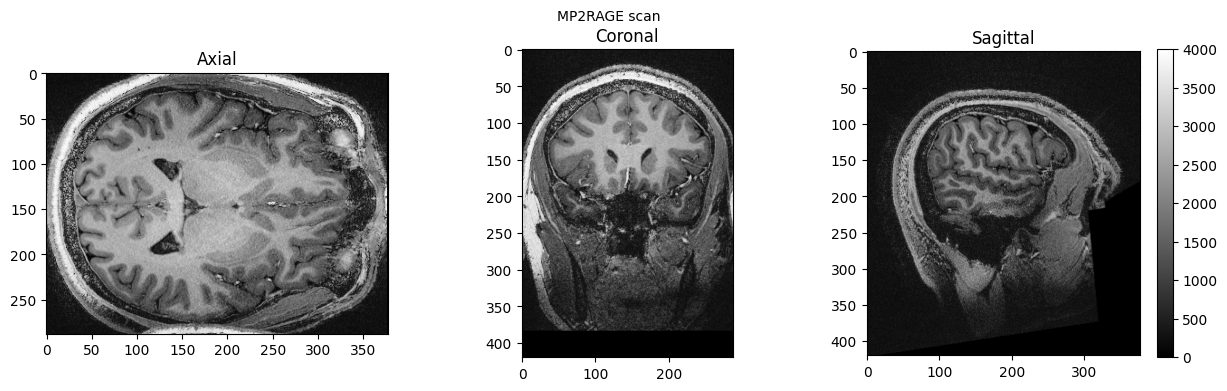

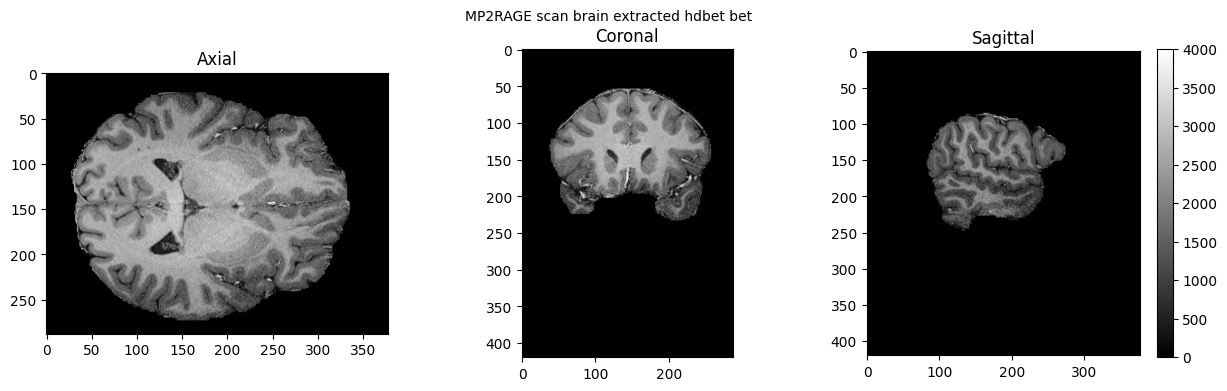

In [14]:
brain_extracted = nib.load('sub-01_ses-01_7T_T1w_defaced_bet.nii.gz').get_fdata()
view_slices_3d(brain, slice_nbr=250, vmin=0, vmax=4000, title='MP2RAGE scan')
view_slices_3d(brain_extracted, slice_nbr=250, vmin=0, vmax=4000, title='MP2RAGE scan brain extracted hdbet bet')

# Showcasing the use of Neurodesk tools in a pipeline system like Nipype

### load afni as well

In [15]:
await lmod.load('afni/22.3.06')
await lmod.list()

['fsl/6.0.4', 'hdbet/1.0.0', 'afni/22.3.06']

###run nipype pipeline

In [16]:
!pip install nipype

In [17]:
!gunzip sub-01_ses-01_7T_T1w_defaced.nii.gz
!ls

apptainer_1.2.0_amd64.deb
apptainer-suid_1.2.0_amd64.deb
cvmfs-release-latest_all.deb
googlecolab_setup.sh
sample_data
sub-01_ses-01_7T_T1w_defaced_bet_mask.nii.gz
sub-01_ses-01_7T_T1w_defaced_bet.nii.gz
sub-01_ses-01_7T_T1w_defaced_brainextracted.nii.gz
sub-01_ses-01_7T_T1w_defaced.nii


In [18]:
from nipype.interfaces import fsl
from nipype.interfaces import afni

os.environ["FSLOUTPUTTYPE"] = "NIFTI"


btr = fsl.BET()
btr.inputs.in_file = '/content/sub-01_ses-01_7T_T1w_defaced.nii'
btr.inputs.frac = 0.4
btr.inputs.out_file = '/content/sub-01_ses-01_7T_T1w_defaced_brain.nii'
res = btr.run()

edge3 = afni.Edge3()
edge3.inputs.in_file = '/content/sub-01_ses-01_7T_T1w_defaced.nii'
edge3.inputs.out_file = '/content/sub-01_ses-01_7T_T1w_defaced_edges.nii'
edge3.inputs.datum = 'byte'
res = edge3.run()

231011-12:38:21,550 nipype.interface INFO:
	 stderr 2023-10-11T12:38:21.550297:++ 3dedge3: AFNI version=AFNI_22.3.06 (Nov 15 2022) [64-bit]


INFO:nipype.interface:stderr 2023-10-11T12:38:21.550297:++ 3dedge3: AFNI version=AFNI_22.3.06 (Nov 15 2022) [64-bit]


231011-12:38:21,558 nipype.interface INFO:
	 stderr 2023-10-11T12:38:21.558392:** AFNI converts NIFTI_datatype=4 (INT16) in file /content/sub-01_ses-01_7T_T1w_defaced.nii to FLOAT32


INFO:nipype.interface:stderr 2023-10-11T12:38:21.558392:** AFNI converts NIFTI_datatype=4 (INT16) in file /content/sub-01_ses-01_7T_T1w_defaced.nii to FLOAT32


231011-12:38:21,561 nipype.interface INFO:
	 stderr 2023-10-11T12:38:21.561601:     Warnings of this type will be muted for this session.


INFO:nipype.interface:stderr 2023-10-11T12:38:21.561601:     Warnings of this type will be muted for this session.


231011-12:38:21,568 nipype.interface INFO:
	 stderr 2023-10-11T12:38:21.561601:     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.


INFO:nipype.interface:stderr 2023-10-11T12:38:21.561601:     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.


231011-12:38:21,570 nipype.interface INFO:
	 stderr 2023-10-11T12:38:21.570580:*+ WARNING:   If you are performing spatial transformations on an oblique dset,


INFO:nipype.interface:stderr 2023-10-11T12:38:21.570580:*+ WARNING:   If you are performing spatial transformations on an oblique dset,


231011-12:38:21,573 nipype.interface INFO:
	 stderr 2023-10-11T12:38:21.570580:  such as /content/sub-01_ses-01_7T_T1w_defaced.nii,


INFO:nipype.interface:stderr 2023-10-11T12:38:21.570580:  such as /content/sub-01_ses-01_7T_T1w_defaced.nii,


231011-12:38:21,576 nipype.interface INFO:
	 stderr 2023-10-11T12:38:21.570580:  or viewing/combining it with volumes of differing obliquity,


INFO:nipype.interface:stderr 2023-10-11T12:38:21.570580:  or viewing/combining it with volumes of differing obliquity,


231011-12:38:21,578 nipype.interface INFO:
	 stderr 2023-10-11T12:38:21.570580:  you should consider running: 


INFO:nipype.interface:stderr 2023-10-11T12:38:21.570580:  you should consider running: 


231011-12:38:21,581 nipype.interface INFO:
	 stderr 2023-10-11T12:38:21.570580:     3dWarp -deoblique 


INFO:nipype.interface:stderr 2023-10-11T12:38:21.570580:     3dWarp -deoblique 


231011-12:38:21,592 nipype.interface INFO:
	 stderr 2023-10-11T12:38:21.570580:  on this and  other oblique datasets in the same session.


INFO:nipype.interface:stderr 2023-10-11T12:38:21.570580:  on this and  other oblique datasets in the same session.


231011-12:38:21,595 nipype.interface INFO:
	 stderr 2023-10-11T12:38:21.570580: See 3dWarp -help for details.


INFO:nipype.interface:stderr 2023-10-11T12:38:21.570580: See 3dWarp -help for details.


231011-12:38:21,598 nipype.interface INFO:
	 stderr 2023-10-11T12:38:21.570580:++ Oblique dataset:/content/sub-01_ses-01_7T_T1w_defaced.nii is 1.253358 degrees from plumb.


INFO:nipype.interface:stderr 2023-10-11T12:38:21.570580:++ Oblique dataset:/content/sub-01_ses-01_7T_T1w_defaced.nii is 1.253358 degrees from plumb.


### visualize results

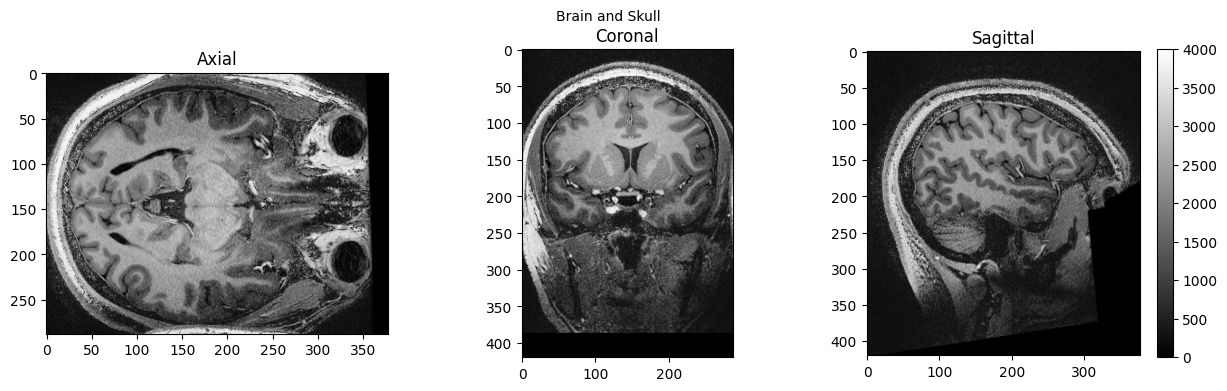

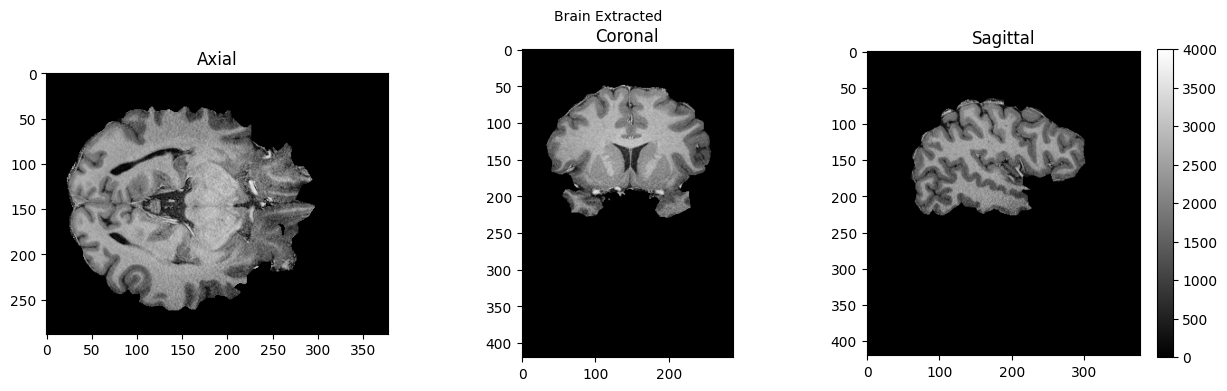

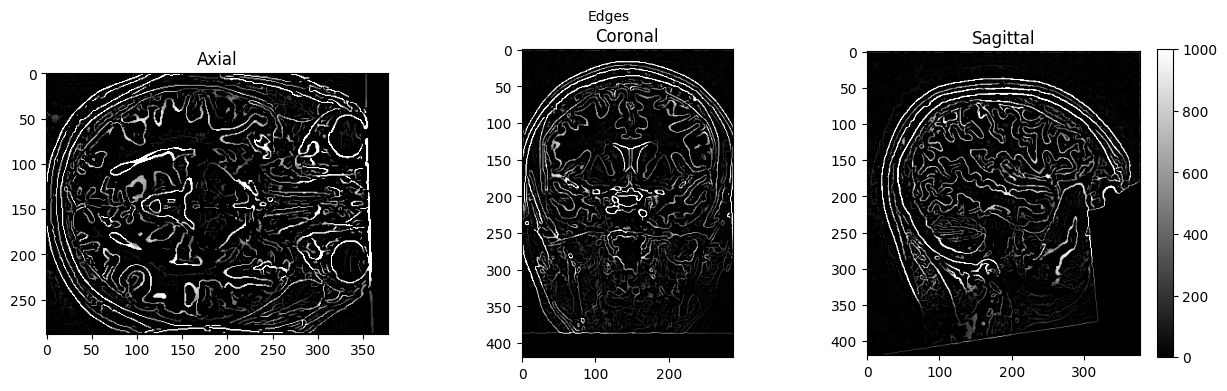

In [21]:
# load data
brain_full = nib.load('sub-01_ses-01_7T_T1w_defaced.nii').get_fdata()
brain = nib.load('sub-01_ses-01_7T_T1w_defaced_brain.nii.gz').get_fdata()
edges = nib.load('sub-01_ses-01_7T_T1w_defaced_edges.nii').get_fdata()


view_slices_3d(brain_full, slice_nbr=230, vmin=0, vmax=4000, title='Brain and Skull')
view_slices_3d(brain, slice_nbr=230, vmin=0, vmax=4000, title='Brain Extracted')
view_slices_3d(edges, slice_nbr=230, vmin=0, vmax=1000, title='Edges')

We hope this is a good illustration of what you can do with Neurodesk :)

**Always make sure to cite the tools you are using in your research. Research software toolkits enable all the work we do and they are still not recognised as a first-class research output and maintainers often work on these in their freetime and there is barely any funding to support our software infrastructure.**

If you find any bugs or would like to contribute to the Neurodesk project, please reach out: https://github.com/orgs/NeuroDesk/discussions

In [26]:
from nipype import Node, Workflow, MapNode
import nipype.interfaces.ants as ants

In [51]:
# Input file paths
patient_01 = abspath('./data/ds000030/sub-10159/anat/sub-10159_T1w.nii.gz')
patient_02 = abspath('./data/ds000030/sub-10171/anat/sub-10171_T1w.nii.gz')
# input_files = [patient_01, patient_02]  # Add paths to your subject images
input_files = patient_01
input_files = Path(input_files)
output_dir = abspath('./output')
mni_template = abspath('./data/template/MNI152_T1_1mm_brain.nii.gz')

In [52]:
# Create Nodes
bet = MapNode(fsl.BET(frac=0.3), name='bet', iterfield=['in_file'])
segmentation = MapNode(fsl.FAST(), name='segmentation', iterfield=['in_files'])

# Ensure RegistrationSynQuick has iterfield set for moving_image
registration = MapNode(ants.RegistrationSynQuick(transform_type='s',
                                                 fixed_image=mni_template),
                       name='registration',
                       iterfield=['moving_image'])

In [53]:
# Workflow
wf = Workflow(name='nucleus_extraction', base_dir=output_dir)


In [54]:
# Connect nodes
wf.connect([
    (bet, segmentation, [('out_file', 'in_files')]),
    # Ensure moving_image is set from the output of a previous node
    (segmentation, registration, [('restored_image', 'moving_image')])
])


In [55]:
os.path.exists(input_files)

False

In [56]:
# Set input files directly on the bet node
bet.inputs.in_file = input_files

TraitError: ignored

In [39]:
wf.run('MultiProc', plugin_args={'n_procs': 1})

231011-13:44:11,362 nipype.workflow INFO:
	 Workflow nucleus_extraction settings: ['check', 'execution', 'logging', 'monitoring']


INFO:nipype.workflow:Workflow nucleus_extraction settings: ['check', 'execution', 'logging', 'monitoring']


231011-13:44:11,764 nipype.workflow INFO:
	 Running in parallel.


INFO:nipype.workflow:Running in parallel.


231011-13:44:11,800 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 11.41/11.41, Free processors: 1/1.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 11.41/11.41, Free processors: 1/1.


231011-13:44:12,67 nipype.workflow ERROR:
	 Node bet failed to run on host 7f554c83338f.


ERROR:nipype.workflow:Node bet failed to run on host 7f554c83338f.


231011-13:44:12,75 nipype.workflow ERROR:
	 Saving crash info to /content/crash-20231011-134412-root-bet-50471c05-8ce0-42f8-bf0b-c0cab5869369.pklz
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/nipype/pipeline/plugins/multiproc.py", line 292, in _send_procs_to_workers
    num_subnodes = self.procs[jobid].num_subnodes()
  File "/usr/local/lib/python3.10/dist-packages/nipype/pipeline/engine/nodes.py", line 1309, in num_subnodes
    self._check_iterfield()
  File "/usr/local/lib/python3.10/dist-packages/nipype/pipeline/engine/nodes.py", line 1332, in _check_iterfield
    raise ValueError(
ValueError: Input in_file was not set but it is listed in iterfields.


When creating this crashfile, the results file corresponding
to the node could not be found.


ERROR:nipype.workflow:Saving crash info to /content/crash-20231011-134412-root-bet-50471c05-8ce0-42f8-bf0b-c0cab5869369.pklz
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/nipype/pipeline/plugins/multiproc.py", line 292, in _send_procs_to_workers
    num_subnodes = self.procs[jobid].num_subnodes()
  File "/usr/local/lib/python3.10/dist-packages/nipype/pipeline/engine/nodes.py", line 1309, in num_subnodes
    self._check_iterfield()
  File "/usr/local/lib/python3.10/dist-packages/nipype/pipeline/engine/nodes.py", line 1332, in _check_iterfield
    raise ValueError(
ValueError: Input in_file was not set but it is listed in iterfields.


When creating this crashfile, the results file corresponding
to the node could not be found.
